# Лабораторная 7. Сентимент-анализ

Задачи классификации текста аналогично обычной задаче классификации предполагает присвоение метки класса некоторому тексту. Здесь можно действовать любыми методами для того, чтобы классифицировать текст, но мы пойдем по следующему пути: векторизуем последовательности (обязательно почитайте про подходы к векторизации, об эмбеддингах) и обучим RNN

После обучения базовых моделей разрешается использовать любой другой подход

За выполнение базовой работы можно получить 15 баллов, за преодоление отметки в 94% точности классификации еще 5 баллов
Удачи!

Примечание: обязательно почитайте про лемматизацию, стеминг, TF-IDF и Word2Vec подходы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv('twitter_training.csv', header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
np.unique(df[1])

array(['Amazon', 'Borderlands', 'CallOfDutyBlackopsColdWar', 'Dota2',
       'NBA2K', 'Overwatch', 'Xbox(Xseries)'], dtype=object)

In [7]:
df = df.drop(0 , axis=1)

In [8]:
df= df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})

In [9]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)
df.head()

,labels,tweets
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [12]:
def getlabel(n) :
    for x , y in df_labels.items() :
        if y==n :
            return x

In [13]:
def DataPrep(text) :
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags

    # tokenization
    tokens = nltk.word_tokenize(text)

    # remove puncs
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]

    # Lemmatization
    words = [lemma.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

In [15]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

In [19]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')
df.drop_duplicates("cleaned_tweets", inplace=True)
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

There are around 2608 duplicated tweets, we will remove them.


<ipython-input-20-518b7af865db>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')


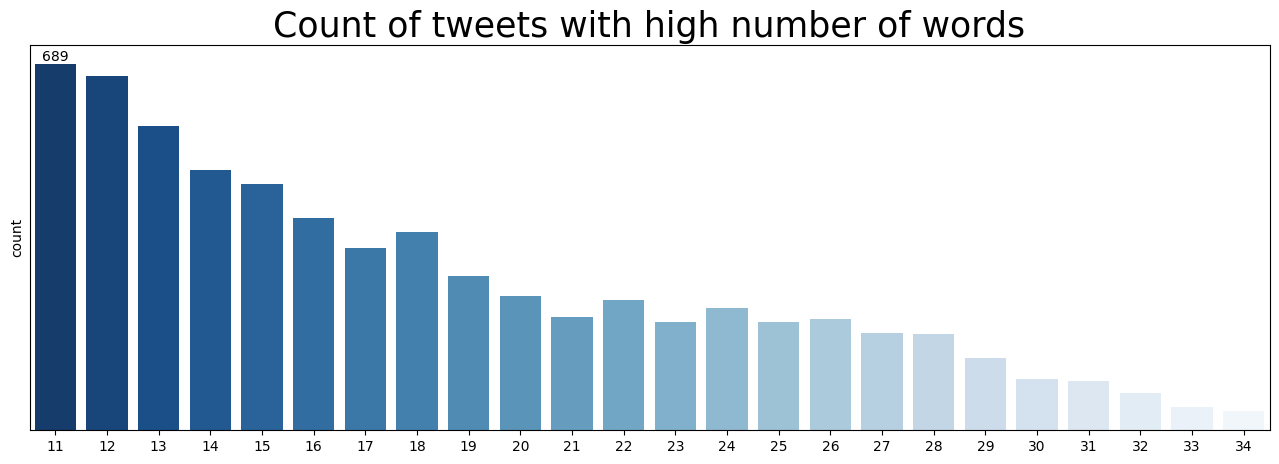

In [20]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Обучаем модели

In [21]:
MAX_LEN = np.max(df['tweet_len'])

In [22]:
def lstm_prep(column , seq_len) :
    # create a vocab of words
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus)
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}

    text_int = []

    for text in column :
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)


    # padding
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) :
        if len(y) <= seq_len :
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y

        else :
            new = y[:seq_len]

        features[idx,:] = np.array(new)

    return sorted_words, features

In [23]:
VOCAB , tokenized_column = lstm_prep(df['cleaned_tweets'] , MAX_LEN)

0it [00:00, ?it/s]

In [24]:
VOCAB[:10]

[('Amazon', 3279),
 ('Borderlands', 3002),
 ('NBAK', 2900),
 ('Overwatch', 2540),
 ('game', 2040),
 ('XboxXseries', 1903),
 ('CallOfDutyBlackopsColdWar', 1882),
 ('Dota', 1752),
 ('Xbox', 958),
 ('like', 906)]

In [25]:
tokenized_column.shape

(13139, 34)

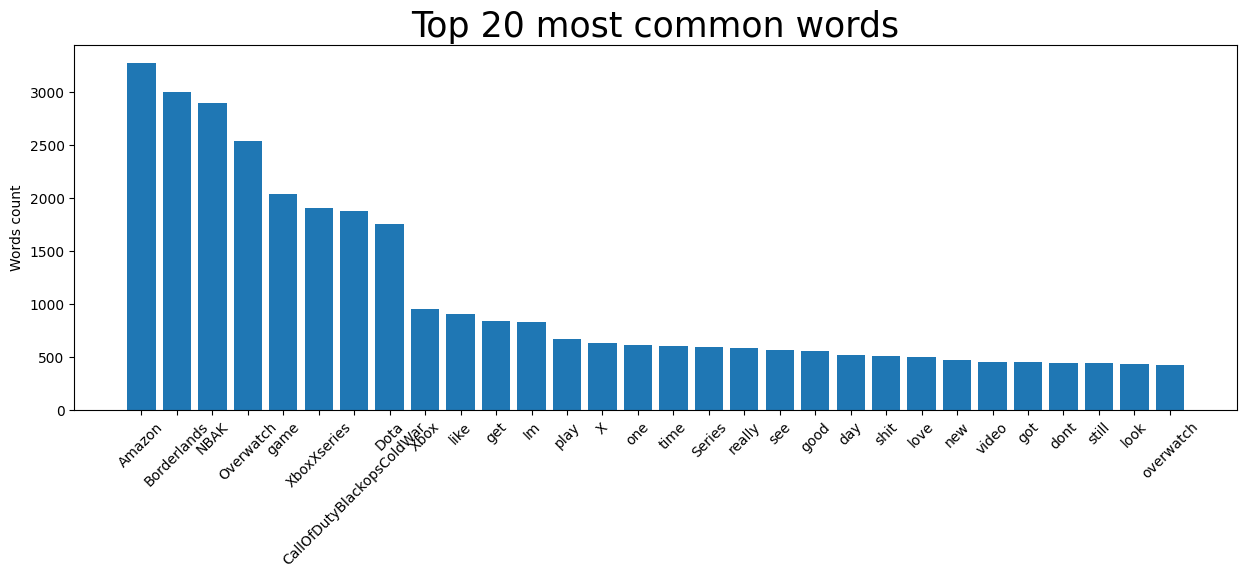

In [26]:
def most_common_words(vocab) :
    keys = []
    values = []
    for key , value in vocab[:30] :
        keys.append(key)
        values.append(value)

    plt.figure(figsize=(15, 5))
    ax = plt.bar(keys, values)
    plt.title('Top 20 most common words', size=25)
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

most_common_words(VOCAB)

In [27]:
X = tokenized_column
y = lb.fit_transform(df['labels'].values)

In [28]:
X_train , X_val , Y_train , Y_val = train_test_split(X , y , train_size=0.85 , random_state=42)

In [29]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

In [61]:
BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset = train_data ,
    batch_size=BATCH_SIZE ,
    shuffle=True
)
val_dataloader = DataLoader(
    dataset = val_data ,
    batch_size = BATCH_SIZE ,
    shuffle=False
)

In [52]:
EMBEDDING_DIM = 300

In [53]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [54]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [34]:
embedding_vec = weight_matrix(word2vec_model,VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

Embedding Matrix Shape: (14379, 300)


In [35]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [77]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, out_channels, bidirectional, dropout=0.5, device='cpu'):
        super().__init__()
        print(device)
        self.no_layers = num_layers
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.requires_grad = False
        self.embedding = self.embedding.to(device)
        self.device = device

        # Свёрточные слои
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # GRU для обработки признаков
        self.lstm = nn.GRU(
            input_size=128,  # Выходный размер от CNN становится входным для GRU
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )

        # Dropout перед полносвязным слоем
        self.dropout = nn.Dropout(p=dropout)

        # Полносвязный слой для классификации
        self.fc = nn.Linear(hidden_dim * self.num_directions, out_channels)

    def forward(self, x):
        # Инициализация скрытого состояния для GRU
        h0 = torch.zeros((self.no_layers * self.num_directions, x.size(0), self.hidden_dim)).to(self.device)

        # Эмбеддинги
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Перестановка размерности для свёрточного слоя
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)

        # Применение CNN
        conv_out = torch.relu(self.conv1(embedded))  # (batch_size, 128, seq_len)
        conv_out = torch.relu(self.conv2(conv_out))  # (batch_size, 128, seq_len)

        # Перестановка размерности обратно для GRU
        conv_out = conv_out.permute(0, 2, 1)  # (batch_size, seq_len, 128)

        # Применение GRU
        out, _ = self.lstm(conv_out, h0)  # (batch_size, seq_len, hidden_dim * num_directions)

        # Берём последнее скрытое состояние GRU
        out = out[:, -1, :]  # (batch_size, hidden_dim * num_directions)

        # Применяем Dropout
        out = self.dropout(out)

        # Полносвязный слой
        out = self.fc(out)  # (batch_size, out_channels)

        return out

In [78]:
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 4
OUT_CHANNELS = 4
HIDDEN_DIM = 256
BIDIRECTIONAL = True
DROPOUT = 0.5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL, DROPOUT, DEVICE)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

if torch.cuda.is_available():
    model = model.cuda()

cuda


In [79]:
param_count(model)

The Total number of parameters in the model :  8621416


In [80]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from sklearn.metrics import accuracy_score

# Определяем критерий, оптимизатор и планировщик
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

# Инициализируем Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Параметры обучения
epochs = 10
training_loss = []
training_acc = []

for i in tqdm(range(epochs)):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    # Тренировочный цикл
    for batch, (x_train, y_train) in enumerate(train_dataloader):
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        optimizer.zero_grad()

        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        # Промежуточный вывод
        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()

        # Считаем потери и точность
        epoch_loss += loss.item()
        epoch_acc += accuracy_score(y_train.cpu(), y_pred.argmax(dim=1).cpu())

    # Средние значения за эпоху
    avg_loss = epoch_loss / len(train_dataloader)
    avg_acc = epoch_acc / len(train_dataloader)
    training_loss.append(avg_loss)
    training_acc.append(avg_acc)

    # Обновляем Scheduler
    scheduler.step(avg_loss)  # Передаём валидационную метрику или потери

    # Вывод статистики
    print(f"Epoch {i+1}: Accuracy: {avg_acc * 100:.2f}%, Loss: {avg_loss:.4f}")
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/11168 samples.
Epoch 1: Accuracy: 48.79%, Loss: 1.1195
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 2: Accuracy: 78.12%, Loss: 0.5790
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 3: Accuracy: 90.89%, Loss: 0.2749
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 4: Accuracy: 95.48%, Loss: 0.1497
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 5: Accuracy: 96.98%, Loss: 0.0979
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 6: Accuracy: 97.83%, Loss: 0.0660
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 7: Accuracy: 98.32%, Loss: 0.0515
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 8: Accuracy: 98.20%, Loss: 0.0553
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 9: Accuracy: 98.56%, Loss: 0.0470
Current Learning Rate: 0.001
Looked at 0/11168 samples.
Epoch 10: Accuracy: 98.95%, Loss: 0.0357
Current Learning Rate: 0.001


## Время Prediction

In [40]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
print(test_df.head())
test_df = test_df.drop(0 , axis=1)

test_df = test_df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})
test_df.head()

      0          1           2  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                   3  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


,Feature2,labels,Feature1
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...


In [41]:
test_df["tweets"]= test_df["Feature1"].astype(str) +" "+ test_df["Feature2"].astype(str)
test_df= test_df.drop(["Feature1","Feature2"],axis=1)

In [42]:
test_df.head()

,labels,tweets
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...


In [81]:
def make_predictions(row):
    random_data = row.sample(len(row))
    random_tweets = random_data['tweets'].values

    cleaned_tweets = []
    for tweet in random_tweets:
        cleaned_tweets.append(DataPrep(tweet))

    y_test = random_data['labels'].values

    # Генерируем числовые данные для LSTM
    _, X_test = lstm_prep(cleaned_tweets, MAX_LEN)
    X_test = torch.from_numpy(X_test).to(DEVICE)

    # Предсказания через модель
    lstm_pred = model(X_test)
    lstm_pred = torch.softmax(lstm_pred, dim=1).argmax(dim=1)
    pred = np.array([getlabel(lstm_pred[i]) for i in range(len(lstm_pred))])

    for i in tqdm(range(100)):
        print(f"The original tweet : {random_tweets[i]}\n")
        print(f"The original label : {y_test[i]}\n")
        print(f"The lstm prediction is : {getlabel(lstm_pred[i])}\n")
        print('-'*120)

    print(f"Accuracy: {accuracy_score(pred, y_test):.2f}")

make_predictions(test_df)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The original tweet : (NA/PC) Come Vibe With Me. Messing Around In GTA !twitter twitch.tv/milzzz_ttd GrandTheftAuto(GTA)

The original label : Irrelevant

The lstm prediction is : Neutral

------------------------------------------------------------------------------------------------------------------------
The original tweet : I didn't have massive success in #IndieApril but I am happy because I saw two reviews on Amazon today. And they made what has been a crappy week in my personal life, a little better
#ReviewMay #Darkfantasy
Here's one detailed review
#NeverGiveUp you will find your audience ☺️ pic.twitter.com/ysjlEgGY7w Amazon

The original label : Neutral

The lstm prediction is : Irrelevant

------------------------------------------------------------------------------------------------------------------------
The original tweet : @PlayApex servers are whack 🙃🤷🏻‍♂️ #ApexLegends pic.twitter.com/A1pzbN3jg7 ApexLegends

The original label : Negative

The lstm prediction is : Posit

## Что дальше?

Попытайтесь улучшить модель (попробуйте GRU), изменить подход к токенизации данных и так далее, удачи!

# После обуения базовой модели используется другой подход

In [99]:
# Загрузка данных
train_file_path = 'twitter_training.csv'
validation_file_path = 'twitter_validation.csv'

# Чтение CSV-файлов
train_data = pd.read_csv(train_file_path, header=None)
validation_data = pd.read_csv(validation_file_path, header=None)

In [100]:
# Оставляем только текст и метки класса
train_data = train_data[[2, 3]]
validation_data = validation_data[[2, 3]]

# Переименование колонок для удобства
train_data.columns = ['label', 'text']
validation_data.columns = ['label', 'text']

In [101]:
from sklearn.preprocessing import LabelEncoder

# Кодируем метки классов
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
validation_data['label'] = label_encoder.transform(validation_data['label'])

In [107]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Очищаем текстовые данные
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'@\w+', '', text)  # Удаление упоминаний
    text = re.sub(r'#\w+', '', text)  # Удаление хэштегов
    text = re.sub(r'\d+', '', text)  # Удаление чисел
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    return text

# Применяем очистку текста
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
validation_data['cleaned_text'] = validation_data['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
# Заменяем NaN значения на пустые строки
train_data['text'] = train_data['text'].fillna("")
validation_data['text'] = validation_data['text'].fillna("")

# Применяем очистку текста
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
validation_data['cleaned_text'] = validation_data['text'].apply(clean_text)

In [109]:
# Заменяем NaN значения на пустые строки
train_data['text'] = train_data['text'].fillna("")
validation_data['text'] = validation_data['text'].fillna("")

# Применяем очистку текста
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
validation_data['cleaned_text'] = validation_data['text'].apply(clean_text)

In [110]:
# Векторизация с использованием TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Преобразование тренировочных и тестовых данных
X_train = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_validation = tfidf_vectorizer.transform(validation_data['cleaned_text'])

# Метки классов
y_train = train_data['label']
y_validation = validation_data['label']

In [111]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_validation_tensor = torch.tensor(X_validation.toarray(), dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.long)

# Создаем датасеты и загрузчики
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

# Определяем модель
class TextClassificationNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Инициализация модели
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
model = TextClassificationNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
epochs = 15
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Оценка на тестовой выборке
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch, _ in validation_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy())

# Оценка точности и метрик
accuracy_nn = accuracy_score(y_validation, y_pred_list)
classification_rep_nn = classification_report(y_validation, y_pred_list, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy_nn}")

Epoch 1/15, Loss: 1170.7607, Accuracy: 58.65%
Epoch 2/15, Loss: 859.6290, Accuracy: 71.20%
Epoch 3/15, Loss: 730.2828, Accuracy: 75.91%
Epoch 4/15, Loss: 629.7776, Accuracy: 79.68%
Epoch 5/15, Loss: 549.4531, Accuracy: 82.37%
Epoch 6/15, Loss: 482.4124, Accuracy: 84.68%
Epoch 7/15, Loss: 433.8307, Accuracy: 86.20%
Epoch 8/15, Loss: 388.4480, Accuracy: 87.77%
Epoch 9/15, Loss: 353.3712, Accuracy: 88.89%
Epoch 10/15, Loss: 324.4598, Accuracy: 89.61%
Epoch 11/15, Loss: 301.5100, Accuracy: 90.24%
Epoch 12/15, Loss: 282.4598, Accuracy: 90.63%
Epoch 13/15, Loss: 264.3593, Accuracy: 91.25%
Epoch 14/15, Loss: 252.4799, Accuracy: 91.58%
Epoch 15/15, Loss: 239.7777, Accuracy: 91.87%
Accuracy: 0.961
